# User Interaction Model for CMD Structure Optimization

## Model Description
### Summary
The purpose of this study is to create a simple User Interaction Model to evaluate alternative approaches to optimizing a user interface.
### Model
$T = M(S, T_C, T_M, C_A, C_G)$

Where $S$ is a command execution scenario expressed as a vector of 
commands, $T_C$ is the time required to switch between commands of the same group, $T_M$ is the time required to switch between commands of different groups, $C_A$ is a set of commands always available at the desktop, $C_G$ is a set of command groups, and T is the time required to execute $S$.

All approaches can be expressed by varying $C_A$ and $C_G$. You need to define these for each approach. A user's expertise level is expressed through $T_C$ and $T_M$.

### Calculating the Time Needed
In this simplified version of the User Interaction Model, we assert that only 2 weights are needed:
* Same group: $T_s$ = command1 to command2
* Different group: $T_d$ = command1 change-group command2

### Approached to be evaluated
* <b>ALL</b> Put all commands on the screen (actually possible with new extra wide LCD screens). This establishes the theoretical optimum.
* <b>NAIVE</b> Naive: make the most frequently executed commands always available.
* <b>GROUP</b> Group heuristics: group together the most used common commands (e.g. delete and move) by doing away the class-verb method for selecting them.
* <b>MRU-B</b> User optimized, based on the most recently used (MRU) commands of a particular user executes more frequently during a training period (batch).
* <b>MRU-O</b> User optimized, based on the most recently used (MRU) commands of a particular user executes more frequently during continuously adjusted (online).
* <b>OPT</b> Optimized: run a (stochastic) optimization algorithm to select those commands whose combination yields the fastest user interaction time. This differs from NAIVE in that it takes into account the actual switching between entities.
* <b>CLUSTER</b> Clustered, based on 2-3 clusters of users. The clustering is performed based on the commands they execute. A stochastic optimization similar to OPT is ran to select the commands executed in each cluster.


## Assumptions
1. We assume that cognitive processes do not affect the time taken to complete a move or a scenario.
2. We assume that all moves need equal time to be carried on, regardless their entity, type or any other characteristic. That time differs only by the expertise of the user.
3. We assume that a scenario will always need the same time to be completed, if the experiment remains the same.

## Data Import
### Experiment Data and Weights

The file format is: init_time, click-on-group_name/click-on-command_group-name_command-name

1497807650.013000 en_objects <br>
1497807651.223000 vm_object_add <br>
1497807655.943000 vm_object_get_attributes <br>

In [2]:
import numpy as np
from scipy import stats

DATA_FOLDER = "" # main results folder

AMATEURS = ["2017-06-18_20-46", "2017-06-19_11-42",
            "2017-06-19_12-07", "2017-06-19_12-18",
            "2017-06-19_12-46", "2017-06-19_13-04",
            "2017-06-19_13-45"]

EXPERTS = ["2017-06-19_18-02", "2017-06-19_18-12",
           "2017-06-19_18-20", "2017-06-19_19-30"]


def cleanse(filename):
    '''
    Get a list of useful data from an experiment file.
    '''
    moves = []
    with open(filename) as test_input:
        for line in test_input:
            move = line.split("\n")[0]
            moves.append([
                float(move.split(" ")[0]),  # Time
                move.split(" ")[1].split("_")[0]  # Action Type
            ])

    return moves


def count_time(moves):
    '''
    Calculate the time needed for every command clicked in an
    experiment data list.
    '''
    action_times = []
    starting_time = float(moves.pop(0)[0])

    command_type = 0  # type 0 means the action involved changing the en
                      # type 1 means the action remained in the same en
    for move in moves:
        if move[1] == "vm":

            action_times.append([
                move[0] - starting_time,  # time taken to since last command
                command_type                      # type of command
            ])

            starting_time = move[0]
            command_type = 1
        else:
            command_type = 0

    return action_times


def input_all():
    '''
    Import all instances, diversified in amateur and expert users.
    '''
    amateur = [np.array(count_time(cleanse(DATA_FOLDER + filename))) 
            for filename in AMATEURS]
    expert = [np.array(count_time(cleanse(DATA_FOLDER + filename)))
            for filename in EXPERTS]
    
    return amateur, expert

def get_avarages(amateur, expert):
    '''
    Get the weights for the model.
    '''
    a_s, a_c, e_s, e_c = [],[],[],[]
    
    for case in amateur:
        a_s += [time[0] for time in case if time[1] == 1]
        a_c += [time[0] for time in case if time[1] == 0]
        
    for case in expert:
        e_s += [time[0] for time in case if time[1] == 1]
        e_c += [time[0] for time in case if time[1] == 0]
    
    weight = {}
    weight['a'] = {'s': stats.trim_mean(a_s, 0.1),
                  'c': stats.trim_mean(a_c, 0.1)}
    weight['e'] = {'s': stats.trim_mean(e_s, 0.1),
                  'c': stats.trim_mean(e_c, 0.1)}
    
    return weight

amateur_times, expert_times = input_all()
weight = get_avarages(amateur_times, expert_times)
print(weight)

{'a': {'s': 5.3476588221157302, 'c': 11.093731189286837}, 'e': {'s': 4.2311320709732341, 'c': 7.300849064341131}}


### Real Scenarios for Valuation
Import scenarios from real data to valuate the different approaches. The file format is:<br>
session-id, user-id, initiation-time(starting from 0), command-group, command-id, command-action:

102:94:393:41:280:<br>
103:95:0:8:27:<br>
103:95:8:8:175:<br>
103:95:51:8:69:5<br>
103:95:72:8:70:4<br>

In [3]:
DATA_FILE = ""

realdata_file = open(DATA_FILE, "r")

def get_scenarios(data):
    '''
    Get real scenarios and their real execution time.
    '''
    # Initialize Variables
    S = []  # Scenarios
    T = []  # Times
    U = []  # Users
    session = '1'
    scenario = []
    time_temp = -1
    user_temp = -1

    for line in data:
        line = line.strip('\n')
        line = line.split(':')
        
        # New Session
        if session != line[1]:

            S.append(scenario)
            scenario = []
            session = line[1]
            T.append(time_temp)
            U.append(user_temp)
        
        # Group
        group = line[5]
        if (group == ''):
            group = -1
        
        scenario.append([line[3], line[4], group])
        time_temp = line[2]
        user_temp = line[1]
    
    return S, T, U

S, T, U = get_scenarios(realdata_file)
scenarios = len(S)
T = [int(time) for time in T]
print(S[1])

[['8', '27', -1], ['8', '28', -1], ['8', '28', -1], ['8', '27', -1], ['8', '29', '2'], ['10', '30', -1], ['10', '31', -1]]


#### Data Segmentation
All: 50% training, 50% evaluation.

Short: 1% training, 50% evaluation.

In [5]:
ALL = int(scenarios/2)
SHORT = int(scenarios/100)

print('ALL: ', ALL)
print('Short:', SHORT)

# Guide:
# S[:ALL] all for training
# S[ALL:] all for evaluation
#
# S[:SHORT] short for training
# S[ALL:] short for evaluation

ALL:  91136
Short: 1822



## Writing Results to CSV

In [6]:
import csv
NAME = '../scoreboard.csv'
METHOD = ['', '', 'ALL', 'NAIVE', 'GROUP', 'MRUB', 'MRUO',
         'OPT(KS)', 'OPT(GA)', 'CLUSTER', 'time']

def p(score,s,t):
    '''
    Get percentages evaluates with the correct CURRENT.
    '''
    return str(round((float(c_score[t]) - float(score)) / \
                     float(c_score[t]) * 100,2)) + '%'

def rt(score):
    '''
    Calculate the relative time score for execution time.
    '''
    total = n_time + g_time + mrub_time + mruo_time + opt_time \
            + ga_time + cl_time
    return str(round(score/total*100,2)) + '%'

def initialize_csv():
    
    Results = []
    Results.append(['182273 scenarios', '', '', '', '1822 scenarios', '', '', ''])
    Results.append(['Method', 'Amateurs', 'Experts', 'Training Time', 'Amateurs',
                    'Experts', 'Time', 'Relative Time'])
    
    Results.append(['ALL', '-', '-', '-', '-', '-', '-', '-']) #2
    Results.append(['NAIVE', '-', '-', '-', '-', '-', '-', '-']) #3
    Results.append(['GROUP', '-', '-', '-', '-', '-', '-', '-']) #4
    Results.append(['MRUB', '-', '-', '-', '-', '-', '-', '-']) #5
    Results.append(['MRUO', '-', '-', '-', '-', '-', '-', '-']) #6
    Results.append(['OPT(KS)', '-', '-', '-', '-', '-', '-', '-']) #7
    Results.append(['OPT(GA)', '-', '-', '-', '-', '-', '-', '-']) #8
    Results.append(['CLUSTER', '-', '-', '-', '-', '-', '-', '-']) #9
    
    with open(NAME, 'w', newline='') as csvfile:
        w = csv.writer(csvfile)
        for row in Results:
            w.writerow(row)
    print(NAME + ' initialized')

def write_csv(value, meth, exp, size):
    
    # Input
    Results = []
    with open(NAME, 'r') as csvfile:
        r = csv.reader(csvfile)
        for row in r:
            Results.append(row)
    
    # Edit
    if (exp == 'a'): ex = 1 
    else: ex = 2
    if (size == 'a'): size = 0 
    else: size = 3
    pos = ex + size
    meth = METHOD.index(meth)
    
    if (exp == 'time'):
        pos = 3 + size
        Results[meth][pos] = value
    else:
        Results[meth][pos] = p(value, 'a', exp) 
    
    # Output
    with open(NAME, 'w', newline='') as csvfile:
        w = csv.writer(csvfile)
        for row in Results:
            w.writerow(row)

#initialize_csv()

## Evaluate Different Approaches

### 0. CURRENT
Calculation of the actual time of command execution with the current setup of the application. The results will differ from those from the real data, as 
1. the real data include time spent on designing and thinking for the way a command is used
2. the weights used here make the assumption that the time of thinking of moving from command to command is the same for all combinations.

Therefore, the $s$ weight is used whenever the command used belongs to the same entity as the previous one and the $c$ when otherwise.

In [7]:
def get_weight_CURRENT(expertise, prv, cur):
    '''
    @param expertise: a for amateurs and e for experts
    @param prv: previous command group and id
    @param cur: current command group and id
    The s weight is used whenever the command used belongs to the 
    same entity as the previous one and the c when otherwise.
    ''' 
    condition = 'c'
    if (prv[0] == cur[0]):
        condition = 's'
    return weight[expertise][condition]


def get_score_CURRENT(S):
    '''
    For every command, add the appropriate weight to the total score.
    '''
    a_score = 0 # amateur score
    e_score = 0 # expert score
    prev_com = ['-1', '-1']
    
    for scenario in S:
        for cur_com in scenario:
            a_score += get_weight_CURRENT('a', prev_com, cur_com)
            e_score += get_weight_CURRENT('e', prev_com, cur_com)
            prev_com = cur_com
        prev_com = ['-1', '-1']
        
    global c_score
    c_score = {'a': round(a_score/60/scenarios,2),
           'e': round(e_score/60/scenarios,2)}
    
    score = 'Amateurs: ' + str(c_score['a'])\
            + ' minutes per scenario' + '\n' + \
            'Experts: ' + str(c_score['e'])\
            + ' minutes per scenario'
    
    return score


print(get_score_CURRENT(S))

Amateurs: 19.56 minutes per scenario
Experts: 14.54 minutes per scenario


#### Evaulation of CURRENT
To find out how these predictions differ from the real data, we plot the actual and predicted data, using the weight for expert users. Those who produces the real data were experts as well:

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def get_predictions_CURRENT(S):
    '''
    For every command, add the appropriate weight to the total score.
    '''
    global predictions
    
    predictions = []
    prev_com = ['-1', '-1']
    
    for scenario in S:
        prediction = 0
        for cur_com in scenario:
            prediction += get_weight_CURRENT('e', prev_com, cur_com)
            prev_com = cur_com
        prev_com = ['-1', '-1']
        predictions.append(prediction/60)
                               
    return predictions

def get_comparison_CURRENT(T, P):
    '''
    Plots CURRENT predictions and real execution time.
    '''
    TvsP = str(round(sum(T)/sum(P),2))
    plt.plot(T, 'b+')
    plt.plot(P, 'g*')
    plt.ylim([0,300])
    plt.ylabel('Execution time (minutes)')
    plt.xlabel('Scenario ID')
    plt.title('Real execution time vs CURRENT\n'\
             +' Real time is '+ TvsP\
             +' times bigger')
    plt.legend(['Real Numbers', 'Predictions'])
    plt.show()
    
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

def CURRENT_REAL_regression(X, Y):
    
    X = np.array(X).reshape(-1, 1)
    X_train = X[:-int(len(X)*0.9)]
    X_test = X[-int(len(X)*0.9):]
    
    Y = np.array(Y).reshape(-1, 1)
    Y_train = Y[:-int(len(Y)*0.9)]
    Y_test = Y[-int(len(Y)*0.9):]
    
    regr = linear_model.LinearRegression()
    regr.fit(X_train,Y_train)
    print('Coefficient: %.2f times' % regr.coef_)
    print('Intercept: %.2f seconds' % regr.intercept_)
    #print('Mean squared error: %.2f'
    #     % mean_squared_error(Y_test, regr.predict(X_test)))
    print('Variance score: %.2f'
         % r2_score(Y_test, regr.predict(X_test)))
    

### 1. ALL
Put all commands on the screen (actually possible with new extra wide LCD screens). This establishes the theoretical optimum.

If every command is on the screen, we assert that the time needed for each one will be the same and equal to the trimmed mean for commands in the same group ($A_S, E_S$).

In [9]:
import time

def get_weight_ALL(expertise):
    '''
    @param expertise: a for amateurs and e for experts
    All commands have the same, non changing weight, as they are
    all available on the screen.
    '''
    return weight[expertise]['s']

def get_score_ALL(S):
    '''
    All are the same, so we count how many commands are used 
    in the scenario and multiply with the appropriate *s* weight.
    '''
    global a_score
    a_score = {}
    a_score['a'] = 0 # amateur score
    a_score['e'] = 0 # expert score
    
    for scenario in S:
        a_score['a'] += len(scenario) * get_weight_ALL('a')
        a_score['e'] += len(scenario) * get_weight_ALL('e')
    
    for t in ['a', 'e']:
        a_score[t] = a_score[t] / SHORT / 60

a_time = time.time()

get_score_ALL(S[SHORT:]) #All has no training, so we just evaluate with ALL:

a_time = round(time.time()-a_time,2)
print('time:',a_time)

# Comparison

print('Amateurs: ' + str(round(a_score['a'],2)) + ' minutes per scenario, ' \
     + str(round((c_score['a']-float(a_score['a']))/c_score['a']*100,2)) + '% less than CURRENT'\
     + '\nExperts: ' +  str(round(a_score['e'],2)) + ' minutes per scenario, '\
     + str(round((c_score['e']-float(a_score['e']))/c_score['e']*100,2)) + '% less than CURRENT')

write_csv(value=a_score['a'], exp='a', meth='ALL', size='a')
write_csv(value=a_score['e'], exp='e', meth='ALL', size='a')
write_csv(value=a_score['a'], exp='a', meth='ALL', size='s')
write_csv(value=a_score['e'], exp='e', meth='ALL', size='s')
write_csv(value='-', exp='time', meth='ALL', size='a')
write_csv(value='-', exp='time', meth='ALL', size='s')

time: 0.85
Amateurs: 1574.7 minutes per scenario, -7950.6% less than CURRENT
Experts: 1245.92 minutes per scenario, -8468.91% less than CURRENT


### 2. NAIVE
Make the most frequently executed commands always available.

First, a list of the most frequently used commands is calculated. Then,
If a command is inside this list, or the group of its previous command
is the same, the $s$ weight will be used. Otherwise, the $c$
weight will be used.

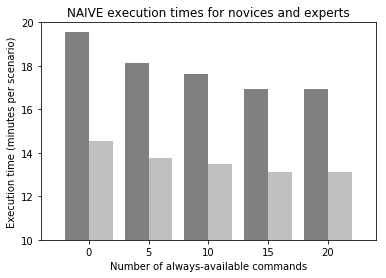

Ex:  [14.539999999999999, 13.782772836163664, 13.491561879499317, 13.136129351781083, 13.136072647246625]
Am:  [19.559999999999999, 18.151107632595821, 17.606002256847582, 16.94068326002138, 16.940577117220617]


In [10]:
DISPLAYED_FREQ_COMMANDS = [0,5,10,15,20]
TOTAL_COMMANDS = 800
import matplotlib.pyplot as plt

import operator

def get_most_frequent_commands(S,f):
    '''
    Returns a list with the f most
    frequent commands.
    '''
    # Initialize freq dictionary
    commands_freq = {}
    for i in range(1,TOTAL_COMMANDS+1):
        commands_freq[i] = 0
            
    # Compute frequencies
    for scenario in S:
        for c in scenario:
            commands_freq[int(c[1])] += 1
    
    most_freq = sorted(commands_freq.items(), key=operator.itemgetter(1))
    
    return [com[0] for com in most_freq[-f:]]

def get_weight_NAIVE(expertise, prv, cur):
    '''
    @param expertise: a for amateurs and e for experts
    @param prv: previous command group and id
    @param cur: current command group and id
    If a command is inside this list, or the group of its previous command
    is the same, the 'same' weight will be used. Otherwise, the 'changed'
    weight will be used.
    ''' 
    condition = 'c'
    if (prv[0] == cur[0]):
        condition = 's'
    if (int(cur[1]) in freq_coms):
        condition = 's'
    return weight[expertise][condition]


def get_score_NAIVE(S):
    '''
    For every command, add the appropriate weight to thte total score.
    '''
    a_score = 0 # amateur score
    e_score = 0 # expert score
    prev_com = ['-1', '-1']
    
    for scenario in S:
        for cur_com in scenario:
            a_score += get_weight_NAIVE('a', prev_com, cur_com)
            e_score += get_weight_NAIVE('e', prev_com, cur_com)
            prev_com = cur_com
        prev_com = ['-1', '-1']
                               
    return [a_score/60/len(S), e_score/60/len(S)]


def get_comparison_NAIVE(St, Se):
    '''
    Plots the execution time for amateurs and experts
    for different amounts of comamnds available on desktop. 
    '''
    # Get scores
    global freq_coms, n_score
    naive_a, naive_e = [],[]
    for f in DISPLAYED_FREQ_COMMANDS[1:]:
        #if (f == 20):
        #    global n_time
        #    n_time = time.time()
        freq_coms = get_most_frequent_commands(St,f)
        #if (f == 20):
        #    n_time = round(time.time()-n_time,2)
        temp = get_score_NAIVE(Se)
        naive_a.append(temp[0])
        naive_e.append(temp[1])
    
    # Add CURRENT
    naive_a = [c_score['a']] + naive_a
    naive_e = [c_score['e']] + naive_e
    
    # n_score
    n_score = {'a' : naive_a[4], 'e' : naive_e[4]}
    
    # Plot Scores
    x = np.array(DISPLAYED_FREQ_COMMANDS)
    ax = plt.subplot(111)
    ax.bar(x-1, naive_a, width=2, color='grey', align='center')
    ax.bar(x+1, naive_e, width=2, color='silver', align='center')
    plt.ylim([10,20])
    plt.xlim([-4,24])
    plt.title('NAIVE execution times for novices and experts')
    plt.ylabel('Execution time (minutes per scenario)')
    plt.xlabel('Number of always-available commands')
    #plt.legend(['Amateurs', 'Experts'])
    plt.savefig("1.eps", format="eps")
    plt.show()
    print('Ex: ', naive_e)
    print('Am: ', naive_a)


get_comparison_NAIVE(S[:SHORT],S[SHORT:])

In [ ]:
write_csv(value=n_score['a'], exp='a', meth='NAIVE', size='a')
write_csv(value=n_score['e'], exp='e', meth='NAIVE', size='a')
write_csv(value=n_time, exp='time', meth='NAIVE', size='a')

Therefore we se how the time significantly decreases when adding up to common commands to the screen and that it stabilizes at around 15 available commands.

Therefore, comparing the $D=15$ version of **NAIVE**, we get the following comparisson with **CURRENT**.

### 3. GROUP
Group heuristics: group together the most used common commands (e.g. delete and move) by doing away the class-verb method for selecting them.

We are using the labels we created on some of the commands:
<u>what command group numbers mean?</u>

When one of these exist in a command, we assume that it is available on the desktop. Therefore for them the $s$ weight is used, as well as for those who belong to the same entity. For the others, the $c$ weight is used.

In [ ]:
a = 0
b = 0

for scenario in S:
    prv = [-1, -1, -1]
    for move in scenario:
        if (int(move[2]) in [1,2,3,4,5,6,7]):
            if (prv[0] == move[0]):
                a += 1
            else:
                b += 1
        prv = move

print(a, b)

In [ ]:
GROUP_ID = [1, 2, 3, 4, 5, 6, 7]


def get_weight_GROUP(expertise, prv, cur):
    '''
    @param expertise: a for amateurs and e for experts
    @param prv: previous command group and id
    @param cur: current command group and id
    @param g: group id to be evaluated or all together
    If a command is in one of the special groupings, 
    or the group of its previous commandis the same, 
    the 'same' weight will be used. Otherwise, the 'changed'
    weight will be used.
    ''' 
    condition = 'c'
    if (int(cur[2]) >= 0):
        condition = 's'
    if (prv[0] == cur[0]):
        condition = 's'
    return weight[expertise][condition]


def get_score_GROUP(S):
    '''
    For every command, add the appropriate weight to thte total score.
    '''
    a_score = 0 # amateur score
    e_score = 0 # expert score
    prev_com = ['-1', '-1']
    
    for scenario in S:
        for cur_com in scenario:
            a_score += get_weight_GROUP('a', prev_com, cur_com)
            e_score += get_weight_GROUP('e', prev_com, cur_com)
            prev_com = cur_com
        prev_com = ['-1', '-1']
        
    #score = 'Amateurs: ' + str(round(a_score,2)) + \
    #        '\nExperts: ' + str(round(e_score,2))
                               
    return [str(round(a_score/60/len(S),2)),
            str(round(e_score/60/len(S),2))]

# Print Results
print('Aggregate GROUP score:')
score = get_score_GROUP(S[:SHORT])
print('Amateurs: ' + score[0] + ' minutes per scenario, ' \
     + str(round((c_score['a']-float(score[0]))/c_score['a']*100,2)) + '% less than CURRENT'\
     + '\nExperts: ' +  score[1] + ' minutes per scenario, '\
     + str(round((c_score['e']-float(score[1]))/c_score['e']*100,2)) + '% less than CURRENT')


In [ ]:
g_score = {'a' : score[0], 'e' : score[1]}
write_csv(value=g_score['a'], exp='a', meth='GROUP', size='a')
write_csv(value=g_score['e'], exp='e', meth='GROUP', size='a')
write_csv(value=g_score['a'], exp='a', meth='GROUP', size='s')
write_csv(value=g_score['e'], exp='e', meth='GROUP', size='s')
write_csv(value=0, exp='time', meth='GROUP', size='a')
write_csv(value=0, exp='time', meth='GROUP', size='s')

Examinging the impact of each command grouping separately, as they have relatively the same frequency, all have a small impact that is almost the same between all of them. Therefore, no command grouping shows to be more potent than the others and displaying all the 7 grouped commands on the screen is suggested.

In comparison to <b>NAIVE</b>, <b>GROUP</b> is more efficient than displaying frequent commands, as NAIVE, even for 10 commands needs additional 0.5 and 1,6 minutes per scenario.

Addionally, while 22% of the commands are grouped, the benefit of using this technique is minimal (less than 1%). This could be because the user who clicks a grouped command (as delete x, edit x, ...) may be almost always already on this entity.

### 4. MRU-B
User optimized, based on the most recently used (MRU) commands of a particular user, when executed more frequently during a training period (batch).

Since we concluded that 15 commands on desktop achieve an almost optimal results and can fit on the users screen, we set $D = 15$

In [ ]:
DISPLAYED_FREQ_COMMANDS = [0,5,10,15,20]
TOTAL_COMMANDS = 800

import operator
import matplotlib.pyplot as plt

def get_most_frequent_commands_MRUB(S,f):
    '''
    Returns a dictionary with the f most
    frequent commands for every user.
    '''
    # Initialize freq dictionary
    commands_freq = {}
    for user in U:
        commands_freq[user] = {}
        for i in range(1,TOTAL_COMMANDS+1):
            commands_freq[user][i] = 0
            
    # Compute frequencies
    for user, scenario in enumerate(S):
        for c in scenario:
            commands_freq[U[user]][int(c[1])] += 1
    
    most_freq = {}
    most_freq_list = {}
    for user in U:
        most_freq[user] = sorted(commands_freq[user].items(), key=operator.itemgetter(1))
        most_freq[user] = most_freq[user][-f:]
        most_freq[user] = [most_freq[user][i][0] for i in range(0,f)]
        
    return most_freq

def get_weight_MRUB(expertise, prv, cur, user):
    '''
    @param expertise: a for amateurs and e for experts
    @param prv: previous command group and id
    @param cur: current command group and id
    If a command is inside this list, or the group of its previous command
    is the same, the 'same' weight will be used. Otherwise, the 'changed'
    weight will be used.
    ''' 
    condition = 'c'
    if (prv[0] == cur[0]):
        condition = 's'
    if (int(cur[1]) in freq_coms[user]):
        condition = 's'
    return weight[expertise][condition]


def get_score_MRUB(S):
    '''
    For every command, add the appropriate weight to thte total score.
    '''
    a_score = 0 # amateur score
    e_score = 0 # expert score
    prev_com = ['-1', '-1']
    
    for user, scenario in enumerate(S):
        for cur_com in scenario:
            a_score += get_weight_MRUB('a', prev_com, cur_com, U[user])
            e_score += get_weight_MRUB('e', prev_com, cur_com, U[user])
            prev_com = cur_com
        prev_com = ['-1', '-1']
        
    #score = 'Amateurs: ' + str(round(a_score,2)) + \
    #        '\nExperts: ' + str(round(e_score,2))
                               
    return [a_score/60/len(S), e_score/60/len(S)]


def get_comparison_MRUB(St,Se):
    '''
    Plots the execution time for amateurs and experts
    for different amounts of comamnds available on desktop. 
    '''
    # Get scores
    global freq_coms, mrub_score
    mrub_a, mrub_e = [],[]
    for f in DISPLAYED_FREQ_COMMANDS[1:]:
        freq_coms = get_most_frequent_commands_MRUB(St,f)
        tt = get_score_MRUB(Se)
        mrub_a.append(tt[0])
        mrub_e.append(tt[1])
    
    # Add CURRENT
    mrub_a = [c_score['a']] + mrub_a
    mrub_e = [c_score['e']] + mrub_e
    
    # Get score for CURRENT comparison
    mrub_score = {'a': mrub_a[3], 'e': mrub_e[3]}
    
    # Plot Scores
    x = np.array(DISPLAYED_FREQ_COMMANDS)
    ax = plt.subplot(111)
    ax.bar(x-1, mrub_a, width=2, color='b', align='center')
    ax.bar(x+1, mrub_e, width=2, color='g', align='center')
    plt.ylim([10,20])
    plt.xlim([-4,24])
    plt.title('MRU-B execution times for experts and amateurs')
    plt.ylabel('Score (minutes per scenario)')
    plt.xlabel('Number of most common commands available on desktop')
    plt.legend(['Amateurs', 'Experts'])
    plt.show()
    print('Am: ', mrub_e)
    print('Ex: ', mrub_a)

          
# Chart Comparison          
get_comparison_MRUB(S,S)

# CURRENT Comparison
print('\nCURRENT and NAIVE comparison with MRUB with 15 displayed commands:')
print('Amateurs: ' + str(round(mrub_score['a'],2)) + ' minutes per scenario, ' \
     + str(round((c_score['a']-float(mrub_score['a']))/c_score['a']*100,2)) + '% less than CURRENT, '\
     + str(round((n_score['a']-float(mrub_score['a']))/n_score['a']*100,2)) + '% less than NAIVE' \
     + '\nExperts: ' +  str(round(mrub_score['e'],2)) + ' minutes per scenario, '\
     + str(round((c_score['e']-float(mrub_score['e']))/c_score['e']*100,2)) + '% less than CURRENT, '\
     + str(round((n_score['e']-float(mrub_score['e']))/n_score['e']*100,2)) + '% less than NAIVE')



For the best-case **MRU-B**, where we the system for the whole dataset, we see results similar to the **NAIVE** approach, that bring a significant decrease in time for 15 displayed commands and a 0.17'' additional decrease for 20 commands, which would be the maximum to display on a typical application.
For 15 displayed commands, **MRU-B** is 15.61% and 11.25% quicker than **CURRENT** for amateurs and experts respectively and  2.26% and 1.55% quicker than **NAIVE**.

In [ ]:
write_csv(value=mrub_score['a'], exp='a', meth='MRUB', size='a')
write_csv(value=mrub_score['e'], exp='e', meth='MRUB', size='a')
write_csv(value=mrub_time, exp='time', meth='MRUB', size='a')

### 5. MRU-O
User optimized, based on the most recently used (MRU) commands of a particular user, executed more frequently during continuously adjusted (online).

* **Option 1**: continuously calculate the frequencies for the user.
* **Option 2**: continuously calculate the frequencies for the user, starting anew for every session.
* **Option 3**: continuously calculate the frequencies for the user, starting a new for every session but using a discunted memory system.


We have seen from **MRU-B** that for $D=20$ desktop-available commands we achieve maximum performance. We keep this stable to better compare the above options.

**Option 1** is evaluated below:

In [ ]:
from heapq import nlargest
import operator

D = 20  # commands available always on desktop

def initialize_most_frequent_commands_MRUO(S,D):
    '''
    Returns a dictionary with the f most
    frequent commands for every user.
    '''
    commands_freq = {}
    for user in U:
        commands_freq[user] = {}
        for i in range(1,TOTAL_COMMANDS+1):
            commands_freq[user][i] = 0

    return commands_freq


def update_most_frequent_commands_MRUO(user, command):
    '''
    Gets a user and a command and updates its frequency.
    ''' 
    
    commands_freq[user][int(command[1])] += 1
    


def is_in_most_frequent_commands_MRUO(user, command):
    '''
    Gets a user and a command and returns true if the
    command is one of the current D most frequent.
    '''   
    freq_coms = nlargest(D, commands_freq[user].items(),
                        operator.itemgetter(1))
    
    if (command in [c[0] for c in freq_coms]):
        return True
    else:
        return False


def get_weight_MRUO(expertise, prv, cur, user):
    '''
    @param expertise: a for amateurs and e for experts
    @param prv: previous command group and id
    @param cur: current command group and id
    If a command is inside this list, or the group of its previous command
    is the same, the 'same' weight will be used. Otherwise, the 'changed'
    weight will be used.
    ''' 
    condition = 'c'
    if (prv[0] == cur[0]):
        condition = 's'
    if (is_in_most_frequent_commands_MRUO(user, int(cur[1]))):
        condition = 's'
    return weight[expertise][condition]


def get_score_MRUO(S):
    '''
    For every command, add the appropriate weight to thte total score.
    '''
    a_score = 0 # amateur score
    e_score = 0 # expert score
    prev_com = ['-1', '-1']
    global commands_freq, mruo_time
    mruo_time = 0
    commands_freq = initialize_most_frequent_commands_MRUO(S, D)
    
    for user, scenario in enumerate(S):
        #print(str(user) + "out of" + str(scenarios))
        for cur_com in scenario:
            a_score += get_weight_MRUO('a', prev_com, cur_com, U[user])
            e_score += get_weight_MRUO('e', prev_com, cur_com, U[user])
            prev_com = cur_com
            temp_time = time.time()
            update_most_frequent_commands_MRUO(U[user], cur_com)
            mruo_time += round(time.time()-temp_time,2)
        prev_com = ['-1', '-1']
    
    global mruo_score
    mruo_score = {'a' : round(a_score/60/len(S),2),
                  'e' : round(e_score/60/len(S),2)}
    print(mruo_score)

# Execution
get_score_MRUO(S[ALL:])
print(mruo_score)
print(mruo_time)

write_csv(value=mruo_score['a'], exp='a', meth='MRUO', size='a')
write_csv(value=mruo_score['e'], exp='e', meth='MRUO', size='a')
write_csv(value=mruo_score['a'], exp='a', meth='MRUO', size='s')
write_csv(value=mruo_score['e'], exp='e', meth='MRUO', size='s')
write_csv(value=mruo_time, exp='time', meth='MRUO', size='a')
write_csv(value=mruo_time, exp='time', meth='MRUO', size='s')

### 6. OPT
Optimized: run a (stochastic) optimization algorithm to select those commands whose combination yields the fastest user interaction time. This differs from NAIVE in that it takes into account the actual switching between entities

**Greedy Knapsack** (Dantzig, 1957): $D$ identical places for $D$ identical-sized items with different values. Order all items with the value they creat by saving time, by ordering them in ascending order. The first $D$ items should be chosen. Additionally and on a stohastic basis, we evaluate only the $F$ most frequent commands, as we assume that the $TOTAL\_COMMANDS - F$ are not likely to be that significant in lowering the execution time of the scenarios, if they appear on desktop.

In [12]:
D = 20  # Number of available commands on desktop
F = 300  # Number of most-frequent commands to have their score evaluated
TOTAL_COMMANDS = 800  # The maximum number of commands

def evaluate_singles(S,D):
    '''
    Calculates a sorted list of the most time-saving commands
    to be always available on desktop and returns the D most
    valuable.
    '''
    
    # score for amateurs only as both groups would give
    # the same results, since they're weight lines are
    # parallel.
    
    gain = {}
    freq = get_most_frequent_commands(S,F)
    
    for command in freq:
        gain[command] = 0
        for scenario in S:
            prev_group = -1
            for move in scenario:
                
                if (command == int(move[1])) and prev_group != move[0]:
                    gain[command] += 1
                prev_group = move[0]

    
    score_list = [0 for i in range(TOTAL_COMMANDS+1)]
    
    for i in range(TOTAL_COMMANDS+1):
        if i in gain.keys():
            score_list[i] = gain[i]
        else:
            score_list[i] = 0
            
    sortedscore = np.array(score_list)
    return sortedscore.argsort()[-D:]


def evaluate_commmands(S, commands):
    '''
    Given a set of Scenarios and the commands that remain on desktop
    It returns the score of that solution.
    '''
    score = {'a': 0, 'e': 0}
    commands = commands.tolist()
    
    for scenario in S:
        prev_group = -1
        for move in scenario:
            # Find Weight Type
            if prev_group == move[0] or int(move[1]) in commands:
                w_type = 's'
            else:
                w_type = 'c'
            
            # Add Score
            score['a'] += weight['a'][w_type]
            score['e'] += weight['e'][w_type]
            
            prev_group = move[0]
    
    return score
    
def optimization(St,Se):
    
    global opt_score, opt_time
    
    # Training
    opt_time = time.time()
    a = evaluate_singles(St,D)
    opt_time = round(time.time()-opt_time,2)
    
    # Evaluation
    opt_score = evaluate_commmands(Se, a)
    for t in ['a', 'e']:
        opt_score[t] = round(opt_score[t]/60/len(Se),2)
    print('done.')

#optimization(S[:ALL],S[ALL:])

In [ ]:
write_csv(value=opt_score['a'], exp='a', meth='OPT(KS)', size='a')
write_csv(value=opt_score['e'], exp='e', meth='OPT(KS)', size='a')
write_csv(value=opt_time, exp='time', meth='OPT(KS)', size='a')

### Difference with NAIVE

* **NAIVE** 20 commands: [72, 71, 73, 28, 53, 44, 81, 85, 35, 47, 48, 63, 57, 62, 27, 50, 41, 42, 38, 40]
* **OPT** 20 commands: [135, 11, 147, 228, 119, 12, 1, 30, 121, 108, 74, 86, 4, 57, 85, 81, 35, 27, 38, 40]

In [ ]:
#NAIVE = [72, 71, 73, 28, 53, 44, 81, 85, 35, 47, 48, 63, 57, 62, 27, 50, 41, 42, 38, 40]
#OPT = [135, 11, 147, 228, 119, 12, 1, 30, 121, 108, 74, 86, 4, 57, 85, 81, 35, 27, 38, 40]

# Comparison
print('\nCURRENT and NAIVE comparison with OPT with 20 displayed commands:')
print('Amateurs: ' + str(round(opt_score['a'],2)) + ' minutes per scenario, '\
     + str(round((c_score['a']-float(opt_score['a']))/c_score['a']*100,2)) + '% less than CURRENT, '\
     + str(round((n_score['a']-float(opt_score['a']))/n_score['a']*100,2)) + '% less than NAIVE, ' \
     + '\nExperts: ' +  str(round(opt_score['e'],2)) + ' minutes per scenario, '\
     + str(round((c_score['e']-float(opt_score['e']))/c_score['e']*100,2)) + '% less than CURRENT, '\
     + str(round((n_score['e']-float(opt_score['e']))/n_score['e']*100,2)) + '% less than NAIVE, ')


**OPT / Stohastic (Genetic) Optimization**


In [ ]:
import random
import datetime
import copy
import time
import operator

D = 20  # Number of available commands on desktop

TOTAL_COMMANDS = 800  # The maximum number of commands

# Sampling


# Genetic Algorithm Variables
Y = 1500  # Number of generations (years)
PS = 50  # Population Size
CR = 0.6  # Crossover Rate
#S_EVAL = 1000  # To randomly evaluate commands on a subset of S
#S_st = random.sample(St,S_EVAL)
M = 0.01  # Mutated propability
E = int(PS * (1-CR))  # Elitist members
geneSet = [i for i in range(1,TOTAL_COMMANDS+1)]
population = generate_initial_population(D,PS)


In [ ]:
def generate_one(D):
    '''
    Generates a random solution with D displayed commands.
    '''
    member = random.sample(geneSet,D)
    return member


def generate_initial_population(D,PS):
    '''
    Create initial population of size PS and D genes.
    '''
    population = [generate_one(D) for i in range(PS)]
    print('Initial population created.')
    return population


def get_fitness(population,S):
    '''
    Evaluate the fitness of a solution using the OPY
    evaluation method.
    '''
    fitness = [evaluate_commmands(S,np.array(member))['a']/len(S)/60
              for member in population]
    return fitness


def mutate(m_population,D,M):
    '''
    Mutate a population, given on a mutation rate.
    '''
    for m in range(len(m_population)):
        for g in range(D):
            r = random.random()
            if (r <= M):
                newGene, alternate = random.sample(geneSet, 2)
                if(m_population[m][g] == newGene):
                    m_population[m][g] = alternate
                else:
                    m_population[m][g] = newGene
    return m_population


def make_child(mom, dad):
    '''
    Create a child from two members.
    '''
    child = []
    for i in range(len(mom)):
        child.append(random.choice([mom[i],dad[i]]))
    return child


def crossover(population,fitness,C):
    cross_pop = []
    for i in range(int(C)):
        mom,dad = roulette_wheel_pop(population, get_propability_list(fitness))
        
        i = [i for i in range(D)]
        r = random.choice(i)
        
        child = mom[:r] + dad[r:]
        cross_pop.append(child)
    return cross_pop

def get_propability_list(fitness):
    '''
    Get propability list for a roulete selection.
    '''
    total_fit = float(sum(fitness))
    relative_fit = [f/total_fit for f in fitness]
    propabilities = [sum(relative_fit[:i+1])
                    for i in range(len(relative_fit))]
    return propabilities


def roulette_wheel_pop(population, propabilities, number=2):
    '''
    Selects randomly a member of their population,
    giving higher priority to those with better fitness.
    '''
    chosen = []
    for n in range(number):
        r = random.random()
        for (i, member) in enumerate(population):
            if (r <= propabilities[i]):
                chosen.append(member)
                break
    return chosen


def elitist(population,fitness):
    '''
    Get the member who survives.
    '''
    index, value = min(enumerate(fitness),
                       key=operator.itemgetter(1))
    elitist = population[index]
    population.pop(index)
    fitness.pop(index)
    
    return population, fitness, elitist
   
    
def evolution_process(S,D,PS,E,Y):
    '''
    Run the evolution process.
    @param S Scenarios
    @param D Displayed commands = No of genes per member
    @param PS Population Size
    @param E Number of Elitists that survive
    @param Y evolution iterations (years)
    '''
    # 0. Initialize Population
    population = generate_initial_population(D,PS)

    for i in range(Y):
        # 1. Evaluate Population Members
        S_st = random.sample(S,3500)
        fitness = get_fitness(population,S_st)

        # 2. Crossover
        new_population = crossover(population, fitness, PS-E)

        # 3. Mutations
        mut_population = mutate(new_population,D,M)
        # 4. Elitists
        elits = []
        for j in range(E):
            population, fitness, elit = elitist(population,fitness)
            elits.append(elit)
            mut_population.append(elit)
        
        
        # 5. Update Population
        population = new_population
        #print(population)
        print(i)
    #print(elits[0],evaluate_commmands(S,np.array(elits[0]))['a']/scenarios/60)
    
    return elits[0]

ga_time = time.time()
ga_list = evolution_process(S[:ALL],D,PS,E,Y)
ga_time = round(time.time()-ga_time,2)
print(ga_time)

ga_score = evaluate_commmands(S[ALL:],np.array(ga_list))
for t in ['a', 'e']:
    ga_score[t] = ga_score[t]/60/len(S[ALL:])
print(ga_list,ga_score)   


#### 2800 Scenarios 

**1st try, 796 iterations:**
[118, 427, 543, 69, 383, 121, 38, 51, 181, 85, 245, 368, 133, 15, 217, 29, 508, 369, 40, 312] 17.5054769999

**2nd try, 1500 iterations:**
[219, 40, 387, 507, 505, 432, 27, 9, 356, 368, 401, 369, 343, 481, 38, 193, 227, 525, 569, 534] 17.3805623832

**3rd try, 2000 iterations:**
[147, 81, 27, 40, 121, 85, 86, 57, 135, 119, 108, 12, 35, 228, 4, 1, 224, 38, 74, 30] 15.8104998208

#### 300000 Scenarios 

** 1200 iterations **
[32, 1, 35, 86, 119, 38, 121, 40, 147, 108, 127, 30, 74, 27, 4, 12, 224, 81, 57, 85] 16.1607420376

In [ ]:
print(ga_score)
write_csv(value=ga_score['a'], exp='a', meth='OPT(GA)', size='s')
write_csv(value=ga_score['e'], exp='e', meth='OPT(GA)', size='s')
write_csv(value=ga_time, exp='time', meth='OPT(GA)', size='s')

In [ ]:
ga_score = evaluate_commmands(S,np.array([
    119, 38, 40, 35, 85, 224, 30, 27, 11, 74, 86, 12, 228, 57, 127, 121, 1, 81, 4, 108]))
for t in ['a', 'e']:
    ga_score[t] = ga_score[t]/60/scenarios

print('\nCURRENT and OPT comparison with OPT with 20 displayed commands:')
print('Amateurs: ' + str(round(ga_score['a'],2)) + ' minutes per scenario, '\
     + str(round((c_score['a']-float(ga_score['a']))/c_score['a']*100,2)) + '% less than CURRENT, '\
     + str(round((ga_score['a']-float(opt_score['a']))/ga_score['a']*100,2)) + '% more than Knapsack OPT, ' \
     + '\nExperts: ' +  str(round(ga_score['e'],2)) + ' minutes per scenario, '\
     + str(round((c_score['e']-float(ga_score['e']))/c_score['e']*100,2)) + '% less than CURRENT, '\
     + str(round((ga_score['e']-float(opt_score['e']))/ga_score['e']*100,2)) + '% less than Knapsack OPT, ')


### 7. CLUSTER
Clustered, based on 2-3 clusters of users. The clustering is performed based on the commands they execute. A stochastic optimization similar to OPT is ran to select the commands executed in each cluster.

A simple way to cluster the users would be to base the clustering on the frequency of the commands they use. However, we want to choose the commands to be displayed always on desktop the time in a way that they minimize the time taken for a scenario to be completed. 

A command can have a 'same-group' time or a 'changing-group' time. therefore, we need to display the frequent commands that are used when user change groups. Therefore, a more appropriate clustering can be done on:
the frequency of commands clicked, counting only if the group was changed immediately before. 

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import time
import operator
TOTAL_COMMANDS = 800

D = 20
CN = 3  # Number of Clusters

def get_user_command_frequencies(S,U):
    '''
    Creates a numpy array with the command frequency
    for every user.
    In the output array, 0th index corresponds to the
    1st user, as it is in the User (U) list.
    '''
    #print(S[scenario][move][command],U[user])
    # Initialize
    U = [int(u) for u in U]
    Cf = [[0 for command in range(TOTAL_COMMANDS)] 
          for user in range(max(U))]
    
    # Get Frequencies
    for user,scenario in enumerate(S):
        for move in scenario:
            Cf[U[user]-1][int(move[1])-1] = Cf[U[user]-1][int(move[1])-1] + 1
    
    return Cf
        

def get_clusters(Cf,CN):
    '''
    Return the clustered users, as a list of their labels.
    KMeans is used for clustering.
    '''
    # Cluster
    X = np.matrix(Cf)
    kmeans = KMeans(n_clusters=CN).fit(X)
    L =  kmeans.labels_
    return L


def get_clustered_scenarios(S,L,U,l):
    '''
    Get the scenarios that correspond to a specific cluster
    of users.
    '''
    S_cluster = []
    
    for user,scenario in enumerate(S):
        if(L[int(U[user])-1] == l):
            S_cluster.append(scenario)
    
    return S_cluster

def get_clusters_OPT(St,Se,U,CN,D):
    '''
    Evaluate CLUSTER by aggregating the OPT scores
    of the clusters.
    '''
    global cl_score, L, cl_time
    
    cl_time = time.time()
    
    # Get Clusters
    Cf = get_user_command_frequencies(St,U[:len(St)])
    L = get_clusters(Cf,CN)
    
    counter = {}
    for i  in range(CN):
        counter[i] = 0
    for user in L:
        counter[i] += 1
    common, value = max(enumerate(counter), key=operator.itemgetter(1))
    
    L = list(L)
    for user in U[len(St):]:
        L.append(int(common))
    L = np.array(L)
    
    S_clustered = [get_clustered_scenarios(St,L,U,l)
                  for l in range(CN)]
    
    # Get Cluster scores
    a = []
    a = [evaluate_singles(S_clustered[l],D)
        for l in range(CN)]
    
    cl_time = round(time.time()-cl_time,2)
    
    # Evaluate
    cl_score_temp = [evaluate_commmands(Se, a[l])
                 for l in range(CN)]
    
    # Aggregate
    cl_score = {'a': 0, 'e': 0}
    for l in range(CN):
        for t in ['a', 'e']:
            cl_score[t] += cl_score_temp[l][t]
    
    # Export
    for t in ['a', 'e']:
        cl_score[t] = round(cl_score[t]/60/len(Se),2)
        
    print('done.')

get_clusters_OPT(S[:SHORT],S[ALL:],U,CN,D)
print(cl_time)
#write_csv(value=opt_score['a'], exp='a', meth='OPT(KS)', size='a')
#write_csv(value=opt_score['e'], exp='e', meth='OPT(KS)', size='a')
write_csv(value=cl_score['a'], exp='a', meth='CLUSTER', size='s')
write_csv(value=cl_score['e'], exp='e', meth='CLUSTER', size='s')
#write_csv(value=opt_time, exp='time', meth='OPT(KS)', size='a')
write_csv(value=cl_time, exp='time', meth='CLUSTER', size='s')

In [ ]:
write_csv(value=cl_score['a'], exp='a', meth='CLUSTER', size='a')
write_csv(value=cl_score['e'], exp='e', meth='CLUSTER', size='a')
write_csv(value=cl_time, exp='time', meth='CLUSTER', size='a')